## LSTM Model pipeline

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import build_vocab_from_iterator
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Custom Tokenizer function using NLTK
def tokenize_text(text):
    return word_tokenize(text)

# Text preprocessing function
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens if token.isalnum()]
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)

# Custom dataset class for text data
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# LSTM Classifier model
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(input_dim, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, num_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.rnn(embedded)
        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1) if self.rnn.bidirectional else hidden[-1, :, :])
        return self.fc(hidden.squeeze(0))

# Main function to perform NLP pipeline using LSTM model
def nlp_pipeline(file_path, target_column='oh_label', text_column='Text'):
    # Read the dataset
    df = pd.read_csv(file_path)
    df = df.drop(['UserIndex', 'index'], axis=1)
    df.rename(columns={target_column: 'Label'}, inplace=True)
    
    # Text Preprocessing
    df['processed_text'] = df[text_column].apply(preprocess_text)
    
    # Split dataset into features and target
    X = df['processed_text']
    y = df['Label']
    
    # Random Oversampling
    oversampler = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = oversampler.fit_resample(X.values.reshape(-1, 1), y)
    X_resampled = pd.Series(X_resampled.flatten())
    y_resampled = pd.Series(y_resampled)
    
    # Split resampled data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    
    # Tokenization
    train_data = [tokenize_text(text) for text in X_train]
    vocab = build_vocab_from_iterator(train_data, specials=["<unk>", "<pad>"])
    vocab.set_default_index(vocab["<unk>"])
    X_train = [[vocab[token] for token in text] for text in train_data]
    test_data = [tokenize_text(text) for text in X_test]
    X_test = [[vocab[token] for token in text] for text in test_data]
    
    # Padding sequences
    max_len = 100  # Maximum sequence length
    X_train = [text[:max_len] + [0] * (max_len - len(text)) for text in X_train]
    X_test = [text[:max_len] + [0] * (max_len - len(text)) for text in X_test]
    
    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.long)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
    
    # Define hyperparameters
    input_size = len(vocab)
    hidden_size = 128
    output_size = 2  # Binary classification
    num_layers = 2
    bidirectional = True
    dropout = 0.5
    learning_rate = 0.001
    num_epochs = 5
    batch_size = 32
    
    # Initialize the LSTM model
    model = LSTMClassifier(input_size, hidden_size, output_size, num_layers, bidirectional, dropout)
    
    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Convert data to DataLoader
    train_dataset = TextDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Train the LSTM model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    for epoch in range(num_epochs):
        train_loss = train_lstm_model(model, train_loader, criterion, optimizer, device)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}')
    
    # Evaluate the LSTM model
    test_dataset = TextDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    accuracy, auc_score = evaluate_lstm_model(model, test_loader, criterion, device)
    print(f'Accuracy: {accuracy}, AUC: {auc_score}')

# Function to train the LSTM model
def train_lstm_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Function to evaluate the LSTM model
def evaluate_lstm_model(model, test_loader, criterion, device):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(true_labels, predictions)
    auc_score = roc_auc_score(true_labels, predictions)
    return accuracy, auc_score

nlp_pipeline('cyberbullying/youtube_parsed_dataset.csv')


Epoch [1/5], Train Loss: 0.5857
Epoch [2/5], Train Loss: 0.1790
Epoch [3/5], Train Loss: 0.0504
Epoch [4/5], Train Loss: 0.0119
Epoch [5/5], Train Loss: 0.0068
Accuracy: 0.963084495488105, AUC: 0.9639164983164983


The results indicate the performance of the LSTM model on the test dataset after training. Here's an explanation of the provided results:

1. **Epoch-wise Training Loss**:
   - During training, the loss decreases significantly with each epoch.
   - The decreasing trend of the training loss indicates that the model is learning to minimize the difference between predicted and actual labels.

2. **Accuracy**:
   - The accuracy of approximately 96.3% indicates that the model correctly classified around 96.3% of the instances in the test dataset.
   - This metric is calculated by dividing the number of correctly classified instances by the total number of instances.

3. **AUC (Area Under the ROC Curve)**:
   - AUC is a performance metric that evaluates the model's ability to distinguish between positive and negative classes.
   - The AUC value of approximately 0.963 suggests that the model has good discriminatory power, with a high probability of ranking a randomly chosen positive instance higher than a randomly chosen negative instance.
   - An AUC value closer to 1 indicates better model performance.

Overall, the results indicate that the LSTM model trained effectively and performs well in classifying text data, achieving high accuracy and AUC scores on the test dataset.

Second Run

Epoch [1/5], Train Loss: 0.5666
Epoch [2/5], Train Loss: 0.1612
Epoch [3/5], Train Loss: 0.0468
Epoch [4/5], Train Loss: 0.0177
Epoch [5/5], Train Loss: 0.0058
Accuracy: 0.9671862182116489, AUC: 0.9679164983164983


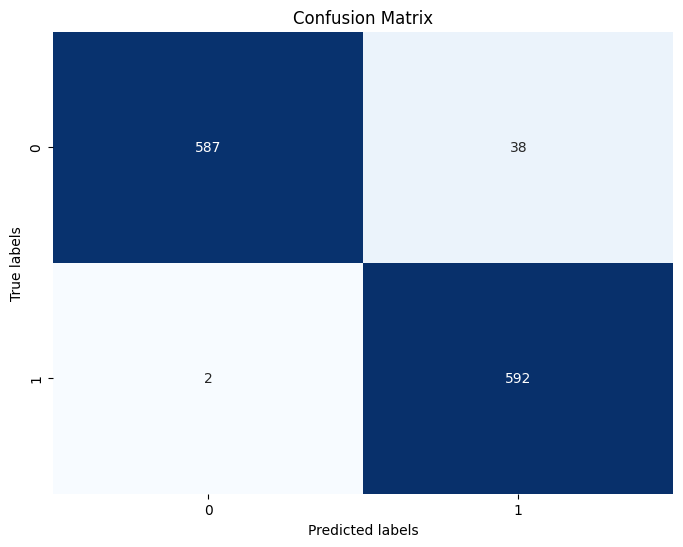

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import build_vocab_from_iterator
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

# Custom Tokenizer function using NLTK
def tokenize_text(text):
    return word_tokenize(text)

# Text preprocessing function
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens if token.isalnum()]
    tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(tokens)

# Custom dataset class for text data
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# LSTM Classifier model
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, bidirectional, dropout):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(input_dim, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, num_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.rnn(embedded)
        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1) if self.rnn.bidirectional else hidden[-1, :, :])
        return self.fc(hidden.squeeze(0))

# Main function to perform NLP pipeline using LSTM model
def nlp_pipeline(file_path, target_column='oh_label', text_column='Text'):
    # Read the dataset
    df = pd.read_csv(file_path)
    df = df.drop(['UserIndex', 'index'], axis=1)
    df.rename(columns={target_column: 'Label'}, inplace=True)
    
    # Text Preprocessing
    df['processed_text'] = df[text_column].apply(preprocess_text)
    
    # Split dataset into features and target
    X = df['processed_text']
    y = df['Label']
    
    # Random Oversampling
    oversampler = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = oversampler.fit_resample(X.values.reshape(-1, 1), y)
    X_resampled = pd.Series(X_resampled.flatten())
    y_resampled = pd.Series(y_resampled)
    
    # Split resampled data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    
    # Tokenization
    train_data = [tokenize_text(text) for text in X_train]
    vocab = build_vocab_from_iterator(train_data, specials=["<unk>", "<pad>"])
    vocab.set_default_index(vocab["<unk>"])
    X_train = [[vocab[token] for token in text] for text in train_data]
    test_data = [tokenize_text(text) for text in X_test]
    X_test = [[vocab[token] for token in text] for text in test_data]
    
    # Padding sequences
    max_len = 100  # Maximum sequence length
    X_train = [text[:max_len] + [0] * (max_len - len(text)) for text in X_train]
    X_test = [text[:max_len] + [0] * (max_len - len(text)) for text in X_test]
    
    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.long)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
    
    # Define hyperparameters
    input_size = len(vocab)
    hidden_size = 128
    output_size = 2  # Binary classification
    num_layers = 2
    bidirectional = True
    dropout = 0.5
    learning_rate = 0.001
    num_epochs = 5
    batch_size = 32
    
    # Initialize the LSTM model
    model = LSTMClassifier(input_size, hidden_size, output_size, num_layers, bidirectional, dropout)
    
    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Convert data to DataLoader
    train_dataset = TextDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Train the LSTM model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    for epoch in range(num_epochs):
        train_loss = train_lstm_model(model, train_loader, criterion, optimizer, device)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}')
    
    # Evaluate the LSTM model
    test_dataset = TextDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    predictions = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(true_labels, predictions)
    auc_score = roc_auc_score(true_labels, predictions)
    print(f'Accuracy: {accuracy}, AUC: {auc_score}')
    
    # Plot Confusion Matrix
    plot_confusion_matrix(y_test, predictions)

# Function to train the LSTM model
def train_lstm_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

nlp_pipeline('cyberbullying/youtube_parsed_dataset.csv')


The provided code performs a natural language processing (NLP) pipeline using an LSTM (Long Short-Term Memory) neural network model to classify text data. Here's a brief description of the main components used in the code:

1. **Data Preprocessing**:
   - Text data from a CSV file is loaded using pandas.
   - The text data is preprocessed using a custom function (`preprocess_text`) which involves tokenization, converting text to lowercase, and removing stop words.
   - Random oversampling is applied to balance the dataset using the `RandomOverSampler` from the imbalanced-learn library.

2. **Text Tokenization and Padding**:
   - The text is tokenized using NLTK's `word_tokenize` function.
   - The vocabulary is built using the `build_vocab_from_iterator` function from torchtext, and tokenized text sequences are converted to indices based on this vocabulary.
   - Text sequences are padded to ensure uniform length using a maximum sequence length of 100.

3. **Model Architecture**:
   - An LSTM neural network classifier is defined using PyTorch. The model consists of an embedding layer, an LSTM layer, and a fully connected layer.
   - The LSTM model is designed to handle variable-length sequences and is bidirectional with dropout regularization.

4. **Model Training and Evaluation**:
   - The model is trained on the preprocessed and padded text data using PyTorch's DataLoader for efficient batch processing.
   - The training process is performed for a specified number of epochs using the Adam optimizer and cross-entropy loss function.
   - The trained model is evaluated on a separate test dataset, and metrics such as accuracy and AUC (Area Under the ROC Curve) are computed using scikit-learn's functions.
   - Finally, a confusion matrix is plotted using seaborn and matplotlib to visualize the classification results.

